In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import librosa as lb
import matplotlib.pyplot as plt

from config import Config

In [2]:
data_dir = "../../../data/dataset/raw/"
subjects = os.listdir(data_dir)

In [3]:
def pre_process_recording(data: pd.DataFrame) -> pd.DataFrame:
    data.drop(columns=["time"], inplace=True)
    data.drop(0, inplace=True)  # Remove first All-0 row
    return data - data.iloc[:10].median()  # Initial position correction

In [4]:
def mean_crossing_rate(x):
    return lb.feature.zero_crossing_rate(x - np.mean(x))[0, 0]


def get_entropy(x, axis=0):
    s = np.sum(x, axis=axis)
    if s != 0:
        x = x / np.sum(x, axis=axis)
    entropy = np.sum(sp.special.entr(x), axis=axis)
    return entropy

def get_stat_features(x, axis=0, prefix=''):

    # print('Calculating Features...', end = " ")
    min = np.min(x, axis=axis)
    max = np.max(x, axis=axis)
    std = np.std(x, axis=axis)
    avg = np.mean(x, axis=axis)
    var = np.var(x, axis=axis)
    ptp = np.ptp(x, axis=axis)
    mrc = np.max(np.diff(x, axis=axis), axis=axis)
    arc = np.mean(np.diff(x, axis=axis), axis=axis)
    src = np.std(np.diff(x, axis=axis), axis=axis)
    mad = sp.stats.median_abs_deviation(x, axis=axis)
    iqr = sp.stats.iqr(x, axis=axis)
    # cor = correlation(x)
    mcr = mean_crossing_rate(x)
    rms = np.sum(np.square(x), axis=axis)
    # print('Done!')

    feature_names = ['min', 'max', 'std', 'avg', 'var',
                     'ptp', 'mrc', 'arc', 'src', 'mad',
                     'iqr', 'mcr', 'rms']
    columnName = [prefix + '_' + sub for sub in feature_names]

    stat_features = pd.DataFrame(np.array([min, max, std, avg,
                                           var, ptp, mrc, arc,
                                           src, mad, iqr,
                                           mcr, rms]
                                          ).reshape(1, -1), columns=columnName)

    if (stat_features.isna().sum().sum()) > 0:
        NaN_columnName = stat_features.columns[stat_features.isna(
        ).any()].tolist()
        raise ValueError(
            f'NaN detected while calculating {prefix} stat features - {NaN_columnName}')

    return stat_features


def get_freq_features(x, axis=0, fs=100, prefix=''):

    # print('Calculating Features...', end = " ")
    nperseg = x.shape[0]

    freq, psd = sp.signal.welch(x, fs, nperseg=nperseg, axis=axis)
    mpw = np.max(psd, axis=axis)
    ent = get_entropy(psd, axis=axis)
    # ctf = np.divide(np.sum((freq * psd), axis=axis), np.sum(psd, axis=axis))
    mxf = np.argmax(psd, axis=axis)
    enr = np.sum(np.square(psd), axis=axis) / nperseg
    skw = sp.stats.skew(x, axis=axis)
    kut = sp.stats.kurtosis(x, axis=axis)
    # print('Done!')

    feature_names = ['mpw', 'ent', 'mxf', 'enr', 'skw', 'kut']
    columnName = [prefix + '_' + sub for sub in feature_names]

    freq_features = pd.DataFrame(np.array([mpw, ent, mxf, enr, skw,
                                           kut]).reshape(1, -1), columns=columnName)

    if (freq_features.isna().sum().sum()) > 0:
        NaN_columnName = freq_features.columns[freq_features.isna(
        ).any()].tolist()
        raise ValueError(
            f'NaN detected while calculating {prefix} freq features - {NaN_columnName}')

    return freq_features


In [5]:
def extract_features(data: pd.DataFrame) -> pd.DataFrame:
    features = pd.DataFrame()
    for column in data.columns:
        x = data[column].to_numpy()
        stat_features = get_stat_features(x, prefix=column)
        spec_features = get_freq_features(x, prefix=column)
        features = pd.concat([features, stat_features, spec_features], axis=1)
        
    return features


In [6]:
test_subject = "007"

In [7]:
train_features = pd.DataFrame()
test_features = pd.DataFrame()

for subject in subjects:
    for gesture in Config.GESTURES:
        gesture_dir = os.path.join(data_dir, subject, gesture)
        recordings = os.listdir(gesture_dir)
        for recording in recordings:
            file_path = os.path.join(gesture_dir, recording)
            data = pd.read_csv(file_path)
            data = pre_process_recording(data)

            if data.shape[0] == 0:
                continue

            # Features v1.0
            data["drf0x"] = data["rf0x"] - data["rpx"]
            data["drf0y"] = data["rf0y"] - data["rpy"]
            data["drf0z"] = data["rf0z"] - data["rpz"]

            data["drf1x"] = data["rf1x"] - data["rpx"]
            data["drf1y"] = data["rf1y"] - data["rpy"]
            data["drf1z"] = data["rf1z"] - data["rpz"]

            _features = extract_features(data[Config.DIST_FEATURES])
            _features["label"] = Config.GESTURES.index(gesture)

            for_training = subject != test_subject
            if for_training:
                train_features = pd.concat([train_features, _features])
            else:
                test_features = pd.concat([test_features, _features])


print(train_features.shape)
print(test_features.shape)


(998, 115)
(161, 115)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)

In [9]:
X_train = train_features.drop(columns=["label"]).to_numpy()
X_test = test_features.drop(columns=["label"]).to_numpy()
y_train = train_features["label"].to_numpy()
y_test = test_features["label"].to_numpy()


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# clf = KNeighborsClassifier(n_neighbors=7)
# clf = RandomForestClassifier(n_estimators=100, max_depth=None)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [12]:
y_pred = clf.predict(X_test)
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))
print(f1_score(y_test, y_pred, average="macro"))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8259815348050642
0.8035714285714286
0.796283040407113
0.7950310559006211
              precision    recall  f1-score   support

           0       0.40      0.17      0.24        12
           1       1.00      0.92      0.96        12
           2       1.00      0.92      0.96        12
           3       1.00      0.67      0.80        12
           4       0.92      1.00      0.96        12
           5       1.00      0.67      0.80        12
           6       1.00      0.92      0.96        12
           7       1.00      0.92      0.96        12
           8       0.35      0.50      0.41        12
           9       1.00      0.83      0.91        12
          10       0.41      0.75      0.53        12
          11       0.56      1.00      0.71         5
          12       0.92      1.00      0.96        12
          13       1.00      1.00      1.00        12

    accuracy                           0.80       161
   macro avg       0.83      0.80      0.80       161
weigh

<AxesSubplot:>

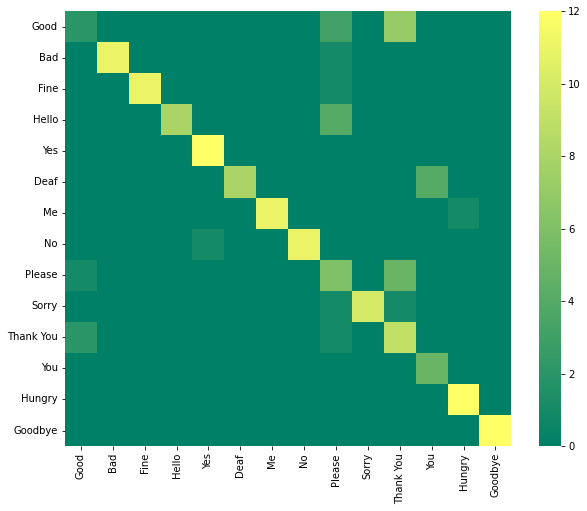

In [13]:
import seaborn as sns

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, xticklabels=Config.GESTURES, yticklabels=Config.GESTURES, cmap="summer")

In [14]:
import joblib
joblib.dump(clf, "../../../models/lr-clf.joblib")

['../../../models/lr-clf.joblib']